In [50]:
#Import packages and define helper functions and objects
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from operator import itemgetter
from itertools import groupby
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
import math
from sklearn.metrics import roc_curve, roc_auc_score  
from sklearn import preprocessing
import pandas as pd

#Converts time string to float value
def string_to_timestamp(date_string):
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)

#Helper objects for encoding the categorical data
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
sm = SMOTE(random_state=42)
df = pd.read_csv('processed.csv')


In [44]:
#Reads the data from the given csv
def get_raw_data() : 
    ah = open('data_for_student_case.csv', 'r')
    data = []
    ah.readline()#skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        txtid =line_ah.strip().split(',')[0]
        bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
        issuercountry = line_ah.strip().split(',')[2]#country code
        issuercountry_set.add(issuercountry)
        txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
        txvariantcode_set.add(txvariantcode)
        issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        currencycode_set.add(currencycode)
        shoppercountry = line_ah.strip().split(',')[7]#country code
        shoppercountry_set.add(shoppercountry)
        interaction = line_ah.strip().split(',')[8]#online transaction or subscription
        interaction_set.add(interaction)
        if line_ah.strip().split(',')[9] == 'Chargeback':
            label = 1#label fraud
        else:
            label = 0#label save
        verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
        verification_set.add(verification)
        cvcresponse = int(line_ah.strip().split(',')[11])#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if cvcresponse > 2:
            cvcresponse = 3
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction 
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
        accountcode_set.add(accountcode)
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
        mail_id_set.add(mail_id)
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
        ip_id_set.add(ip_id)
        card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
        card_id_set.add(card_id)
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                    shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                     accountcode, mail_id, ip_id, card_id, label, creationdate,  txtid])
    data = sorted(data, key = lambda k: k[-1])
    return data

In [56]:
#Process the raw data so one can apply ML to it 
def pre_process_data(data):
    x = []
    y = []
    
    for item in data:
        feats = item[0:-3]
        label = item[-3]
        amount_GBP = conv_curr_2_GBP (item[4], item[3])
        txtid = item[-1]
        feats.append(amount_GBP)
        feats.extend(get_aggr_data(txtid))
        x.append(feats)
        y.append(label)
        
    x = encode_categorical_features(x)
    return (preprocessing.scale(np.array(x), axis=0),np.array(y))

def get_aggr_data(txtid):
    feats = []
    row = df.loc[df['txid'] == int(txtid)]
    feats.append(row.iloc[0]['past_fraud_card'])
    feats.append(row.iloc[0]['number_same_day'])
    feats.append(row.iloc[0]['amount_same_day'])
    feats.append(row.iloc[0]['past_fraud_ip'])
    return feats


#Encode the categorical features by mapping strings to integers 
def encode_categorical_features(x):
    for item in list(issuercountry_set):
        issuercountry_dict[item] = list(issuercountry_set).index(item)
    for item in list(txvariantcode_set):
        txvariantcode_dict[item] = list(txvariantcode_set).index(item)
    for item in list(currencycode_set):
        currencycode_dict[item] = list(currencycode_set).index(item)
    for item in list(shoppercountry_set):
        shoppercountry_dict[item] = list(shoppercountry_set).index(item)
    for item in list(interaction_set):
        interaction_dict[item] = list(interaction_set).index(item)
    for item in list(verification_set):
        verification_dict[item] = list(verification_set).index(item)
    for item in list(accountcode_set):
        accountcode_dict[item] = list(accountcode_set).index(item)
    for item in x:
        item[0] = issuercountry_dict[item[0]]
        item[1] = txvariantcode_dict[item[1]]
        item[4] = currencycode_dict[item[4]]
        item[5] = shoppercountry_dict[item[5]]
        item[6] = interaction_dict[item[6]]
        item[7] = verification_dict[item[7]]
        item[10] = accountcode_dict[item[10]]
    return x

#Convert currency to British Pounds
def conv_curr_2_GBP (currencycode, amount):
    rates = {'NZD':0.46, 'AUD':0.49, 'GBP':1, 'MXN':0.04, 'SEK':0.08}
    rate = rates[currencycode]
    return rate*amount


In [26]:
# Plot roc curve
def plot_roc_curve(clf, y_test, x_test, name='Receiver operating characteristic'):
    
    # predict probabilities
    probs = clf.predict_proba(x_test)  
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()

In [24]:
#Run the ML algorithm using cross-validation
def evaluate_classifier(x,y,clf, use_PCA = False):
    TP, FP, FN, TN = 0, 0, 0, 0
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if use_PCA:
            pca = PCA(n_components=2)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)
            
        x_train, y_train = sm.fit_resample(x_train, y_train)
        
        clf.fit(x_train, y_train)
        y_predict = clf.predict(x_test)
        for i in range(len(y_predict)):
            if y_test[i]==1 and y_predict[i]==1:
                TP += 1
            if y_test[i]==0 and y_predict[i]==1:
                FP += 1
            if y_test[i]==1 and y_predict[i]==0:
                FN += 1
            if y_test[i]==0 and y_predict[i]==0:
                TN += 1
    tp_avg = TP/10
    fp_avg = FP/10
    fn_avg = FN/10
    tn_avg = TN/10
    
    acc = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)
    specif = TN / (FP + TN)
    prec = TP/(TP+FP) 
    fp_rate = FP/(FP+TN)
    
    print ('TP: '+ str(TP))
    print ('FP: '+ str(FP))
    print ('FN: '+ str(FN))
    print ('TN: '+ str(TN))
    
    print ('FP Rate : '+ str(fp_rate))

    
    print('Accuracy:' + str(acc))
    print('Recall:' + str(recall))
    print('Specificity:' + str(specif))
    print('Precision:' + str(prec))

#Run the ML algorithm withour cross validation 
def test_classifier(x,y,clf, use_PCA=False, name='Receiver operating characteristic'):
    TP, FP, FN, TN = 0.0000001, 0.0000001, 0.0000001, 0.0000001
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)   
    x_train, y_train = sm.fit_resample(x_train, y_train)
   # print(x_train)
    if use_PCA:
        pca = PCA(n_components=2)
        pca.fit(x_train)

        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
        #plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.Set1,edgecolor='k')
        
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    for i in range(len(y_predict)):
        if y_test[i]==1 and y_predict[i]==1:
            TP += 1
        if y_test[i]==0 and y_predict[i]==1:
            FP += 1
        if y_test[i]==1 and y_predict[i]==0:
            FN += 1
        if y_test[i]==0 and y_predict[i]==0:
            TN += 1
    acc = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)
    specif = TN / (FP + TN)
    prec = TP/(TP+FP) 
    tp_rate = TP/(TP+FN)
    fp_rate = FP/(FP+TN)
    
    plot_roc_curve(clf, y_test, x_test, name)
    
    print ('TP: '+ str(TP))
    print ('FP: '+ str(FP))
    print ('FN: '+ str(FN))
    print ('TN: '+ str(TN))
    
    print ('TP Rate : '+ str(tp_rate))
    print ('FP Rate : '+ str(fp_rate))

    
    print('Accuracy:' + str(acc))
    print('Recall:' + str(recall))
    print('Specificity:' + str(specif))
    print('Precision:' + str(prec))

In [10]:
#Pipeline
data = get_raw_data()
(x,y) = pre_process_data(data)

fraud = 0
non_fraud = 0
for cls in y:
    if cls == 0:
        non_fraud += 1
    if cls == 1:
        fraud += 1
        
#Iterate over all classifiers
classifiers = []
classifiers.append((neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'distance'), "Distance Weighed KNN"))
classifiers.append((RandomForestClassifier(n_estimators=1000), "Random Forest Classifier"))
classifiers.append((BaggingClassifier(base_estimator= svm.SVC(kernel = 'rbf', gamma='auto'), max_samples=0.001, bootstrap=False, n_estimators=1000, verbose=0), "Bagged SVM"))
classifiers.append((ExtraTreesClassifier(n_estimators=1000, max_depth=None,min_samples_split=2, random_state=0, criterion='entropy'), "Extra Random Forest Classifier with entropy criterion"))
classifiers.append((AdaBoostClassifier(n_estimators=1000), "AdaBoost Classifier"))

for (clf, name) in classifiers:
    print(name)
    evaluate_classifier(x,y,clf)



C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Random Forest Classifier
TP: 38
FP: 376
FN: 307
TN: 235977
TP Rate : 0.11014492753623188
FP Rate : 0.001590840818606068
Accuracy:0.9971144665354165
Recall:0.11014492753623188
Specificity:0.998409159181394
Precision:0.09178743961352658
Bagged SVM
TP: 309
FP: 37871
FN: 36
TN: 198482
TP Rate : 0.8956521739130435
FP Rate : 0.1602306719186979
Accuracy:0.8398507803192253
Recall:0.8956521739130435
Specificity:0.8397693280813021
Precision:0.008093242535358827
Extra Random Forest Classifier with entropy criterion
TP: 38
FP: 289
FN: 307
TN: 236064
TP Rate : 0.11014492753623188
FP Rate : 0.0012227473313222172
Accuracy:0.997482023506747
Recall:0.11014492753623188
Specificity:0.9987772526686778
Precision:0.1162079510703364
AdaBoost Classifier
TP: 267
FP: 28699
FN: 78
TN: 207654
TP Rate : 0.7739130434782608
FP Rate : 0.12142431024780731
Accuracy:0.8784231383450641
Recall:0.7739130434782608
Specificity:0.8785756897521927
Precision:0.009217703514465235
Distance Weighed KNN
TP: 83
FP: 2850
FN: 262
TN: 

C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


345
236353
SMOTE


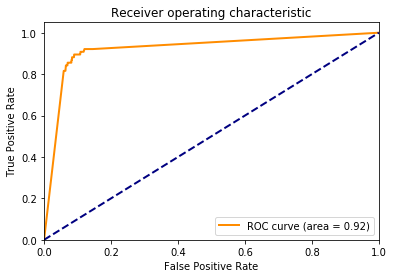

TP: 67.0000001
FP: 4118.0000001
FN: 9.000000100000001
TN: 43146.0000001
TP Rate : 0.881578946364266
FP Rate : 0.08712762356301994
Accuracy:0.9128221377235926
Recall:0.881578946364266
Specificity:0.91287237643698
Precision:0.016009557968171585


In [57]:
data = get_raw_data()
(x,y) = pre_process_data(data)

fraud = 0
non_fraud = 0
for cls in y:
    if cls == 0:
        non_fraud += 1
    if cls == 1:
        fraud += 1
print(fraud)
print(non_fraud)

#clf = svm.LinearSVC( class_weight={0:math.sqrt(fraud), 1:math.sqrt(non_fraud)})
clf = BaggingClassifier(base_estimator= svm.SVC(kernel = 'rbf', gamma='auto'), max_samples=0.01, bootstrap=False, n_estimators=100, verbose=0)

print("SMOTE")
test_classifier(x,y,clf, use_PCA=False)



In [ ]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'distance')
print("SMOTE")
test_classifier(x,y,clf,ub_method = sm, use_PCA=False)
print("Near Miss")
test_classifier(x,y,clf,ub_method = nm, use_PCA=False)


In [49]:
get_aggr_data(1)

1
   Unnamed: 0  txid          bookingdate issuercountrycode txvariantcode  \
0           0     1  2015-11-09 14:26:51                MX      mccredit   

        bin  amount currencycode shoppercountrycode shopperinteraction  ...  \
0  530056.0  2592.0          MXN                 MX          Ecommerce  ...   

          creationdate    accountcode     mail_id     ip_id     card_id  \
0  2015-07-01 23:03:11  MexicoAccount  email68370  ip111778  card184798   

  creationdate_day past_fraud_card number_same_day amount_same_day  \
0       2015-07-01               0               0               0   

   past_fraud_ip  
0              0  

[1 rows x 23 columns]


[0, 0, 0, 0]

In [28]:
clf = ExtraTreesClassifier(n_estimators=20, max_depth=None,min_samples_split=2, random_state=0, criterion='entropy')
test_classifier(x,y,clf,use_PCA=True)

TP: 47
FP: 3353
FN: 20
TN: 43920
TP Rate : 0.7014925373134329
FP Rate : 0.07092843695132528
Accuracy:0.9287494719053654
Recall:0.7014925373134329
Specificity:0.9290715630486747
Precision:0.013823529411764707


In [6]:
clf = AdaBoostClassifier(n_estimators=1000)
test_classifier(x,y,clf,ub_method = sm, use_PCA=False)
test_classifier(x,y,clf,ub_method = sm, use_PCA=True)


TP: 50.0000001
FP: 2551.0000001
FN: 28.0000001
TN: 44711.0000001
TP Rate : 0.6410256406640368
FP Rate : 0.05397570987451239
Accuracy:0.9455217574951793
Recall:0.6410256406640368
Specificity:0.9460242901254876
Precision:0.01922337566172831
TP: 71.0000001
FP: 6424.0000001
FN: 10.000000100000001
TN: 40835.0000001
TP Rate : 0.8765432089468069
FP Rate : 0.13593178019155744
Accuracy:0.8640895648469448
Recall:0.8765432089468069
Specificity:0.8640682198084425
Precision:0.010931485773335442


In [17]:
print(x[0])

[6.51126894e-08 6.92688185e-09 3.84184955e-04 1.33245499e-04
 2.77075274e-09 7.96591412e-08 0.00000000e+00 6.92688185e-10
 0.00000000e+00 9.99999897e-01 1.38537637e-09 1.06998851e-04
 7.70698728e-05 1.51829631e-04 5.32981997e-06]
